# **Sujet : Reconnaissance de caractères**
<p>Développer un code pour détecter des caractères.<p>

<br>https://francescopochetti.com/text-recognition-natural-scenes/

In [320]:
import os
from google.colab import drive
drive.mount('drive')
!mkdir -p drive -v
cwd = os.getcwd()

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [321]:
import math
import matplotlib.pyplot
import numpy
import skimage
import scipy
import sklearn
import glob
import cv2
import tensorflow

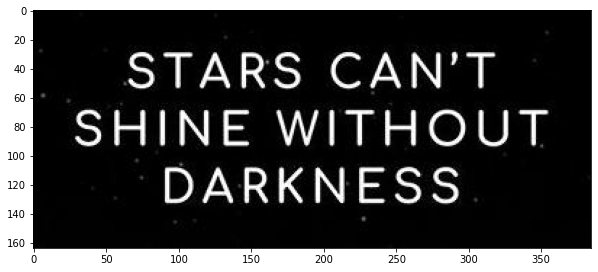

In [332]:
from skimage.io import imread
from matplotlib.pyplot import figure, imshow

img_gray = imread('drive/My Drive/Colab Notebooks/image01.jpg', as_gray=True) # lecture de l'image
img_rgb = imread('drive/My Drive/Colab Notebooks/image01.jpg', as_gray=False) # lecture de l'image
img_height, img_width = img_gray.shape
figure(figsize=(10, 10)) # visualisation
imshow(img_gray, cmap='gray') # visualisation de l'image image.jpg

1. **Denoising** : <br>This is done applying a <a href="https://en.wikipedia.org/wiki/Total_variation_denoising">**total variation approach**</a> which consists in reducing as much as possible the integral of the absolute gradient of the image, where the gradient of an image can simply be interpreted as a directional change in the intensity or color in the image itself.
<br>http://gael-varoquaux.info/scipy-lecture-notes/advanced/image_processing/auto_examples/plot_face_tv_denoise.html

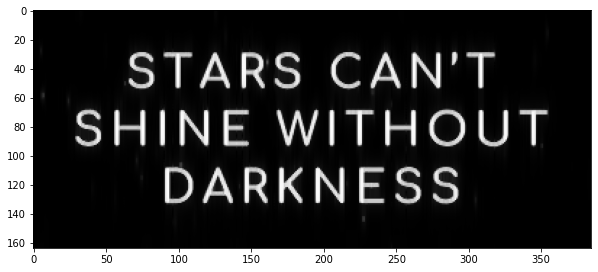

In [333]:
from skimage.restoration import denoise_tv_chambolle
from matplotlib.pyplot import figure, imshow

img_tvDenoised = denoise_tv_chambolle(img_gray, weight=0.2, multichannel=True) # Using total variation filter denoising
figure(figsize=(10, 10)) # visualisation
imshow(img_tvDenoised, cmap='gray') # visualisation de l'image img_tvDenoised.png

2. **Increasing Contrast** : <br>This is done applying <a href="https://en.wikipedia.org/wiki/Otsu%27s_method">**Otsu‘s method**</a> which calculates an “optimal” threshold by maximizing the variance between two classes of pixels,  separated by the threshold. Equivalently, this threshold minimizes the intra-class variance.
<br>https://www.meccanismocomplesso.org/en/opencv-python-the-otsus-binarization-for-thresholding/
<br>https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html

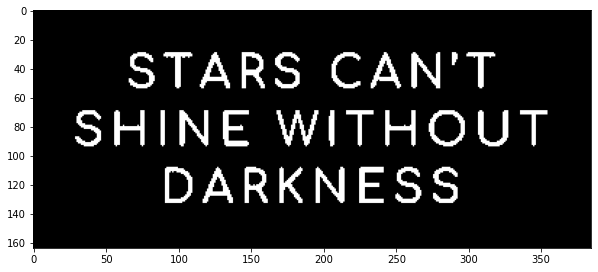

In [334]:
from skimage.filters import threshold_otsu
from matplotlib.pyplot import figure, imshow

thresh = threshold_otsu(img_tvDenoised)
img_binary = img_tvDenoised > thresh

figure(figsize=(10, 10)) # visualisation
imshow(img_binary, cmap='gray')

3. **Object Detection** : Contours are identified and a rectangle is drawn around objects candidates.
<br>https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html
<br>https://scikit-image.org/docs/0.8.0/api/skimage.measure.find_contours.html
<br>https://muthu.co/draw-bounding-box-around-contours-skimage/

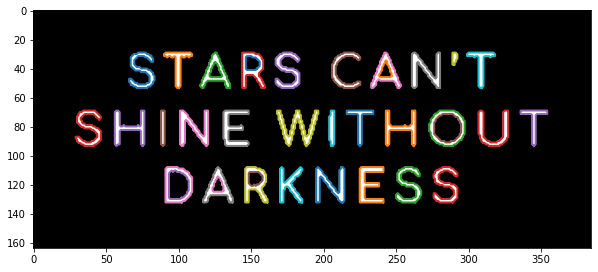

In [335]:
from skimage.measure import find_contours
from matplotlib.pyplot import figure, plot, imshow

# Find contours at a constant value of 0.8
contours = find_contours(img_binary, level=0.8)

# Display the image and plot all contours found
figure(figsize=(10, 10)) # visualisation

for contour in contours:
  plot(contour[:, 1], contour[:, 0], linewidth=2)

imshow(img_binary, cmap='gray')
# matplotlib.pyplot.gca().invert_yaxis()

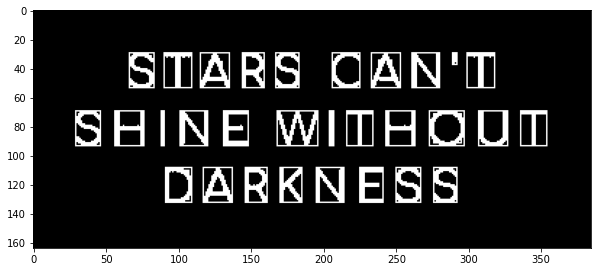

In [336]:
from numpy import copy, min, max
from skimage.draw import polygon_perimeter
from matplotlib.pyplot import figure, imshow
# from skimage.util import invert

bounding_boxes = []
img_with_boxes = copy(img_binary)

for contour in contours:
  Xmin = min(contour[:, 0])
  Xmax = max(contour[:, 0])
  Ymin = min(contour[:, 1])
  Ymax = max(contour[:, 1])
  
  bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
  # print([int(Xmin), int(Xmax), int(Ymin), int(Ymax)])

for box in bounding_boxes:
  # [Xmin, Xmax, Ymin, Ymax]
  r = [box[0], box[1], box[1], box[0], box[0]]
  c = [box[3], box[3], box[2], box[2], box[3]]
  
  rr, cc = polygon_perimeter(r, c, img_with_boxes.shape)
  img_with_boxes[rr, cc] = 1 # set color white

# with_boxes = invert(with_boxes)

figure(figsize=(10, 10)) # visualisation
imshow(img_with_boxes, cmap="gray")

In [337]:
bounding_boxes_new = bounding_boxes.copy()

for box_i in bounding_boxes:
  i_Xmin = box_i[0]
  i_Xmax = box_i[1]
  i_Ymin = box_i[2]
  i_Ymax = box_i[3]

  for box_j in bounding_boxes:
    j_Xmin = box_j[0]
    j_Xmax = box_j[1]
    j_Ymin = box_j[2]
    j_Ymax = box_j[3]

    if (j_Xmin > i_Xmin) and (j_Xmax < i_Xmax) and (j_Ymin > i_Ymin) and (j_Ymax < i_Ymax):
      bounding_boxes_new.remove([j_Xmin, j_Xmax, j_Ymin, j_Ymax])

print('Before : ', len(bounding_boxes), 'After : ', len(bounding_boxes_new))

Before :  37 After :  30


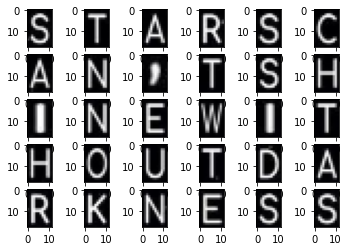

In [338]:
from numpy import zeros
from math import ceil, floor
from skimage.transform import resize

img_num = len(bounding_boxes_new)

fig = matplotlib.pyplot.figure()
img_list_resize = zeros(shape=(img_num, 18, 12, 3))

for box in range(img_num):
  # nb_subplot = ceil(math.sqrt(len(bounding_boxes))) # if we have 38 images, we output 7*7 subplot
  # ax = fig.add_subplot(nb_subplot, nb_subplot, box+1)

  nb_subplot = ceil(img_num/6)
  ax = fig.add_subplot(nb_subplot, 6, box+1)

  # bias_width = 36 - (ceil(bounding_boxes[box][1]) - floor(bounding_boxes[box][0]))
  # bias_heigh = 24 - (ceil(bounding_boxes[box][3]) - floor(bounding_boxes[box][2]))
  # mean_bw = bias_width / 2
  # mean_bh = bias_heigh / 2
  add_edge = 3

  # img_binary[rect_bottom:rect_top, rect_left:rect_right]
  img_patch = img_rgb[floor(bounding_boxes_new[box][0]-add_edge):ceil(bounding_boxes_new[box][1]+add_edge),
                      floor(bounding_boxes_new[box][2]-add_edge):ceil(bounding_boxes_new[box][3]+add_edge)]
  img_resize = resize(img_patch, (18, 12, 3))
  img_list_resize[box] = img_resize
  ax.imshow(img_resize, cmap="gray")

4. **Text Detection** : The challenge now is to detect which ones of the identified objects contain text in order to be able to classify it. Basically I have to train a model to make such a decision which means that first of all I need a proper dataset, consisting ideally of half images containing text and half not containing it.<br>
I took images from the 78903 available in the <a href="http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/">74K Chars dataset</a>.
<br>https://github.com/mitchellvitez/chars74k/blob/master/chars74k.py
<br>https://vitez.me/real-world-character-recognition
<br>https://stackoverflow.com/questions/45593820/image-converted-by-skimage-color-rgba-to-rgb-is-saved-as-rgba-by-matplotlib-imsa

In [329]:
from skimage.transform import resize
from matplotlib.image import imread
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

SAMPLES = 7700
CHARS = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
ROWS = 18
COLS = 12

images = numpy.zeros(shape=(SAMPLES, ROWS, COLS, 3))
labels = numpy.zeros(shape=(SAMPLES,), dtype=int)
sample_num = 0
for sample in sorted(glob.glob('drive/My Drive/Colab Notebooks/English/Img/GoodImg/Bmp/*')):
  for image in glob.glob(sample + '/*'):
    images[sample_num] = resize(imread(image), (ROWS, COLS))
    labels[sample_num] = int(sample[-2:]) - 1
    sample_num += 1

images, images_test, labels, labels_test = train_test_split(images, labels, test_size=0.2)

print(f'{images.shape[0]} sample images of size {images.shape[1]}x{images.shape[2]}')
print(f'{labels.shape[0]} labels')
assert images.shape[0] == labels.shape[0]

layers = \
  [Convolution2D(128, 3, 3, input_shape=(ROWS, COLS, 3), activation='relu'),
   Convolution2D(256, 2, 1, activation='relu'),
   Convolution2D(512, 2, 1, activation='relu'),
   MaxPooling2D(pool_size=(2, 2)),
   Flatten(), Dense(1024, activation='relu'),
   Dropout(0.5), Dense(512, activation='relu'),
   Dropout(0.5), Dense(62), Activation('softmax')]

model = Sequential()
for layer in layers:
    model.add(layer)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(images, labels, epochs=30, batch_size=128, validation_data=(images_test, labels_test))
model.summary()

6160 sample images of size 18x12
6160 labels
Epoch 1/30
49/49 [==============================] - 14s 284ms/step - loss: 3.8678 - accuracy: 0.0635 - val_loss: 3.7571 - val_accuracy: 0.0825
Epoch 2/30
49/49 [==============================] - 14s 279ms/step - loss: 3.7360 - accuracy: 0.0833 - val_loss: 3.4816 - val_accuracy: 0.1597
Epoch 3/30
49/49 [==============================] - 14s 279ms/step - loss: 3.0970 - accuracy: 0.2506 - val_loss: 2.5150 - val_accuracy: 0.3734
Epoch 4/30
49/49 [==============================] - 14s 280ms/step - loss: 2.3296 - accuracy: 0.4068 - val_loss: 1.9602 - val_accuracy: 0.4753
Epoch 5/30
49/49 [==============================] - 14s 279ms/step - loss: 1.8377 - accuracy: 0.5076 - val_loss: 1.5104 - val_accuracy: 0.5727
Epoch 6/30
49/49 [==============================] - 14s 278ms/step - loss: 1.5282 - accuracy: 0.5797 - val_loss: 1.3227 - val_accuracy: 0.6325
Epoch 7/30
49/49 [==============================] - 14s 278ms/step - loss: 1.3089 - accuracy: 0.6

In [339]:
from numpy import argmax

predictions = model.predict(img_list_resize)
img_list_text = []

for index in range(img_num):
  # imshow(img_list_resize[i])
  text_detected = CHARS[argmax(predictions[index])]
  img_list_text.append(text_detected)
  # print('prediction : ', text_detected)

print('Prediction : ', img_list_text)

Prediction :  ['s', 't', 'a', 'r', 's', 'c', 'a', 'n', 'i', 't', 's', 'h', 'L', 'n', 'e', 'w', 'i', 't', 'h', 'O', 'u', 't', 'd', 'a', 'r', 'k', 'n', 'e', 's', 's']


5. **Text Reconstruction** : This is the last part of the work and simply consists in putting together all the pieces of the puzzle we have build so far. Just to recap, we have characters with rectangles coordinates from the original image and predictions. What we can do is simply build an other figure plotting the predicted strings in the right positions.
<br>https://matplotlib.org/stable/tutorials/text/text_intro.html

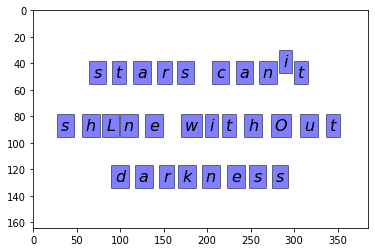

In [340]:
fig = matplotlib.pyplot.figure()
ax = fig.add_subplot()

# Set both x- and y-axis limits to [0, *] instead of default [0, 1]
ax.axis([0, img_width, img_height, 0])

for index in range(img_num):
  pos_x = int((bounding_boxes_new[index][1] + bounding_boxes_new[index][0]) / 2)
  pos_y = int((bounding_boxes_new[index][3] + bounding_boxes_new[index][2]) / 2)

  ax.text(pos_y, pos_x, img_list_text[index], style='italic', fontsize=16,
          verticalalignment='top', horizontalalignment='center',
          bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 4})

matplotlib.pyplot.show()